<a href="https://colab.research.google.com/github/animeshgaur25/Cross-selling-Insurance/blob/main/Cross_selling_insurance.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
from sklearn import preprocessing
from mlxtend.frequent_patterns import apriori  
from mlxtend.frequent_patterns import association_rules 
from sklearn.model_selection import train_test_split
import sklearn.metrics as metrics
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report,confusion_matrix 
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, LambdaCallback
import warnings

from sklearn.ensemble import VotingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import BaggingClassifier
warnings.filterwarnings('ignore')

In [ ]:
import seaborn as sns; sns.set_theme()


#Reading Data

In [ ]:
data = pd.read_csv('train.csv', index_col='ID')
test = pd.read_csv('test.csv', index_col='ID')

In [ ]:
data

,City_Code,Region_Code,Accomodation_Type,Reco_Insurance_Type,Upper_Age,Lower_Age,Is_Spouse,Health Indicator,Holding_Policy_Duration,Holding_Policy_Type,Reco_Policy_Cat,Reco_Policy_Premium,Response
ID,,,,,,,,,,,,,
1,C3,3213,Rented,Individual,36,36,No,X1,14+,3.0,22,11628.0,0
2,C5,1117,Owned,Joint,75,22,No,X2,NaN,NaN,22,30510.0,0
3,C5,3732,Owned,Individual,32,32,No,NaN,1.0,1.0,19,7450.0,1
4,C24,4378,Owned,Joint,52,48,No,X1,14+,3.0,19,17780.0,0
5,C8,2190,Rented,Individual,44,44,No,X2,3.0,1.0,16,10404.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
50878,C4,845,Rented,Individual,22,22,No,X3,NaN,NaN,18,7704.0,0
50879,C5,4188,Rented,Individual,27,27,No,X3,7.0,3.0,4,5408.0,0
50880,C1,442,Rented,Individual,63,63,No,X2,14+,1.0,12,11374.0,0


#Data Preprocessing

In [ ]:
data['Region_Code_label'] = pd.cut(data['Region_Code'], 40, labels = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40])
test['Region_Code_label'] = pd.cut(test['Region_Code'], 40, labels = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40])

In [ ]:
X = data.iloc[:]
X = X.drop(['Response'], axis=1)
y = data.iloc[:,12]

In [ ]:
data_cat = X.select_dtypes(include=['object']).columns
data_num = X.select_dtypes(exclude=['object']).columns

In [ ]:
data_num

Index(['Region_Code', 'Upper_Age', 'Lower_Age', 'Holding_Policy_Type',
       'Reco_Policy_Cat', 'Reco_Policy_Premium', 'Region_Code_label'],
      dtype='object')

In [ ]:
numerical_features=X[data_num]
categorical_features=X[data_cat]
numerical_features_test=test[data_num]
categorical_features_test=test[data_cat]

In [ ]:
numerical_features = numerical_features.drop(['Region_Code','Region_Code_label','Upper_Age', 'Lower_Age', 'Holding_Policy_Type',	'Reco_Policy_Cat'], axis=1)
numerical_features_test = numerical_features_test.drop(['Region_Code','Region_Code_label','Upper_Age', 'Lower_Age', 'Holding_Policy_Type',	'Reco_Policy_Cat'], axis=1)

In [ ]:
categorical_features = categorical_features.drop(['Holding_Policy_Duration'], axis=1)
categorical_features_test = categorical_features_test.drop(['Holding_Policy_Duration'], axis=1)

In [ ]:
X['Holding_Policy_Duration'] = X['Holding_Policy_Duration'].str.replace('+', ' ')
X['Holding_Policy_Duration'] = pd.to_numeric(X['Holding_Policy_Duration'], errors='coerce')
test['Holding_Policy_Duration'] = test['Holding_Policy_Duration'].str.replace('+', ' ')
test['Holding_Policy_Duration'] = pd.to_numeric(test['Holding_Policy_Duration'], errors='coerce')

In [ ]:
numerical_features = pd.concat([numerical_features, X['Holding_Policy_Duration']], axis=1)
numerical_features_test = pd.concat([numerical_features_test, test['Holding_Policy_Duration']], axis=1)

In [ ]:
print("NAs for numerical features in train : " + str(numerical_features.isna().values.sum()))
numerical_features = numerical_features.fillna(numerical_features.median())
print("Remaining NAs for numerical features in train : " + str(numerical_features.isna().values.sum()))

print("NAs for numerical features in test : " + str(numerical_features_test.isnull().values.sum()))
numerical_features_test = numerical_features_test.fillna(numerical_features_test.median())
print("Remaining NAs for numerical features in test : " + str(numerical_features_test.isnull().values.sum()))

NAs for numerical features in train : 20251
Remaining NAs for numerical features in train : 0
NAs for numerical features in test : 8603
Remaining NAs for numerical features in test : 0


In [ ]:
numerical_features_norm = (numerical_features-numerical_features.min())/(numerical_features.max()-numerical_features.min())
numerical_features_norm.head()

numerical_features_norm_test = (numerical_features_test-numerical_features_test.min())/(numerical_features_test.max()-numerical_features_test.min())
numerical_features_norm_test

,Reco_Policy_Premium,Holding_Policy_Duration
ID,,
50883,0.235009,0.384615
50884,0.722007,0.153846
50885,0.170286,0.076923
50886,0.166587,0.153846
50887,0.489669,0.307692
...,...,...
72683,0.329906,0.230769
72684,0.462185,0.384615
72685,0.376802,0.307692


In [ ]:
categorical_features_2 = X.iloc[:,[4,5,9,10,-1]]
categorical_features_test_2 = test.iloc[:,[4,5, 9,10, -1]]

In [ ]:
categorical_features =  pd.concat([categorical_features, categorical_features_2.astype(str)], axis = 1)
categorical_features_test =  pd.concat([categorical_features_test, categorical_features_test_2.astype(str)], axis = 1)

In [ ]:
categorical_features = categorical_features.fillna(method = 'ffill')
categorical_features_test = categorical_features_test.fillna(method = 'ffill')

In [ ]:
categorical_features_test.shape

(21805, 10)

In [ ]:
categorical_features

,City_Code,Accomodation_Type,Reco_Insurance_Type,Is_Spouse,Health Indicator,Upper_Age,Lower_Age,Holding_Policy_Type,Reco_Policy_Cat,Region_Code_label
ID,,,,,,,,,,
1,C3,Rented,Individual,No,X1,36,36,3.0,22,21
2,C5,Owned,Joint,No,X2,75,22,nan,22,8
3,C5,Owned,Individual,No,X2,32,32,1.0,19,25
4,C24,Owned,Joint,No,X1,52,48,3.0,19,29
5,C8,Rented,Individual,No,X2,44,44,1.0,16,15
...,...,...,...,...,...,...,...,...,...,...
50878,C4,Rented,Individual,No,X3,22,22,nan,18,6
50879,C5,Rented,Individual,No,X3,27,27,3.0,4,28
50880,C1,Rented,Individual,No,X2,63,63,1.0,12,3


In [ ]:
import copy
train_objs_num = len(categorical_features)
dataset = pd.concat(objs=[categorical_features, categorical_features_test], axis=0)
dataset = pd.get_dummies(dataset)
categorical_features = copy.copy(dataset[:train_objs_num])
categorical_features_test = copy.copy(dataset[train_objs_num:])

In [ ]:
test_new =  pd.concat([numerical_features_norm_test, categorical_features_test], axis = 1)
X_new =  pd.concat([numerical_features_norm, categorical_features], axis = 1)

In [ ]:
X_new

,Reco_Policy_Premium,Holding_Policy_Duration,City_Code_C1,City_Code_C10,City_Code_C11,City_Code_C12,City_Code_C13,City_Code_C14,City_Code_C15,City_Code_C16,City_Code_C17,City_Code_C18,City_Code_C19,City_Code_C2,City_Code_C20,City_Code_C21,City_Code_C22,City_Code_C23,City_Code_C24,City_Code_C25,City_Code_C26,City_Code_C27,City_Code_C28,City_Code_C29,City_Code_C3,City_Code_C30,City_Code_C31,City_Code_C32,City_Code_C33,City_Code_C34,City_Code_C35,City_Code_C36,City_Code_C4,City_Code_C5,City_Code_C6,City_Code_C7,City_Code_C8,City_Code_C9,Accomodation_Type_Owned,Accomodation_Type_Rented,...,Region_Code_label_1,Region_Code_label_10,Region_Code_label_11,Region_Code_label_12,Region_Code_label_13,Region_Code_label_14,Region_Code_label_15,Region_Code_label_16,Region_Code_label_17,Region_Code_label_18,Region_Code_label_19,Region_Code_label_2,Region_Code_label_20,Region_Code_label_21,Region_Code_label_22,Region_Code_label_23,Region_Code_label_24,Region_Code_label_25,Region_Code_label_26,Region_Code_label_27,Region_Code_label_28,Region_Code_label_29,Region_Code_label_3,Region_Code_label_30,Region_Code_label_31,Region_Code_label_32,Region_Code_label_33,Region_Code_label_34,Region_Code_label_35,Region_Code_label_36,Region_Code_label_37,Region_Code_label_38,Region_Code_label_39,Region_Code_label_4,Region_Code_label_40,Region_Code_label_5,Region_Code_label_6,Region_Code_label_7,Region_Code_label_8,Region_Code_label_9
ID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,0.227609,1.000000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0.687356,0.307692,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
3,0.125881,0.000000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0.377401,1.000000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
5,0.197807,0.153846,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,...,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
50878,0.132066,0.307692,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
50879,0.076162,0.461538,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
50880,0.221425,1.000000,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [ ]:
test_new

,Reco_Policy_Premium,Holding_Policy_Duration,City_Code_C1,City_Code_C10,City_Code_C11,City_Code_C12,City_Code_C13,City_Code_C14,City_Code_C15,City_Code_C16,City_Code_C17,City_Code_C18,City_Code_C19,City_Code_C2,City_Code_C20,City_Code_C21,City_Code_C22,City_Code_C23,City_Code_C24,City_Code_C25,City_Code_C26,City_Code_C27,City_Code_C28,City_Code_C29,City_Code_C3,City_Code_C30,City_Code_C31,City_Code_C32,City_Code_C33,City_Code_C34,City_Code_C35,City_Code_C36,City_Code_C4,City_Code_C5,City_Code_C6,City_Code_C7,City_Code_C8,City_Code_C9,Accomodation_Type_Owned,Accomodation_Type_Rented,...,Region_Code_label_1,Region_Code_label_10,Region_Code_label_11,Region_Code_label_12,Region_Code_label_13,Region_Code_label_14,Region_Code_label_15,Region_Code_label_16,Region_Code_label_17,Region_Code_label_18,Region_Code_label_19,Region_Code_label_2,Region_Code_label_20,Region_Code_label_21,Region_Code_label_22,Region_Code_label_23,Region_Code_label_24,Region_Code_label_25,Region_Code_label_26,Region_Code_label_27,Region_Code_label_28,Region_Code_label_29,Region_Code_label_3,Region_Code_label_30,Region_Code_label_31,Region_Code_label_32,Region_Code_label_33,Region_Code_label_34,Region_Code_label_35,Region_Code_label_36,Region_Code_label_37,Region_Code_label_38,Region_Code_label_39,Region_Code_label_4,Region_Code_label_40,Region_Code_label_5,Region_Code_label_6,Region_Code_label_7,Region_Code_label_8,Region_Code_label_9
ID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
50883,0.235009,0.384615,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
50884,0.722007,0.153846,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,...,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
50885,0.170286,0.076923,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
50886,0.166587,0.153846,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
50887,0.489669,0.307692,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
72683,0.329906,0.230769,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
72684,0.462185,0.384615,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
72685,0.376802,0.307692,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


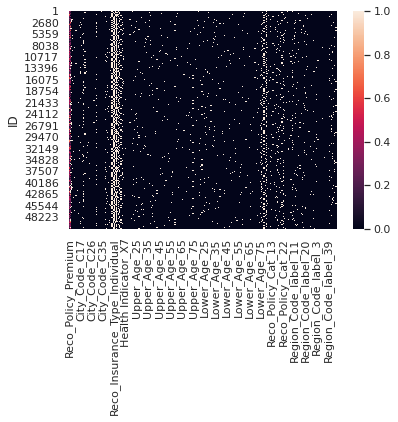

In [ ]:
ax = sns.heatmap(X_new)

Train-test split

In [ ]:
from imblearn.over_sampling import SMOTE
sm = SMOTE()
X_train, X_test, y_train, y_test = train_test_split(X_new, y, test_size=0.25, random_state=0, shuffle= False)
X_new_oversampled, y_train = sm.fit_sample(X_train, y_train)
X_train = pd.DataFrame(X_new_oversampled, columns=X_train.columns)


#Models

**KNN**

In [ ]:
KNN3 = KNeighborsClassifier(n_neighbors=3, metric='euclidean')
KNN3m = KNeighborsClassifier(n_neighbors=3, metric='manhattan')

In [ ]:
KNN3.fit(X_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='manhattan',
                     metric_params=None, n_jobs=None, n_neighbors=3, p=2,
                     weights='uniform')

In [ ]:
# Predict results on the testing part
Y_pred = KNN3.predict(X_test)
print("Number of mislabeled points out of a total %d points : %d" % (X_test.shape[0], (y_test != Y_pred).sum()))

Number of mislabeled points out of a total 12721 points : 4521


In [ ]:
print(classification_report(y_test,Y_pred))
print("Confusion Matrix")
print(confusion_matrix(y_test,Y_pred))
print("\n Accuracy")
print(accuracy_score(y_test,Y_pred))

              precision    recall  f1-score   support

           0       0.77      0.76      0.76      9619
           1       0.28      0.30      0.29      3102

    accuracy                           0.64     12721
   macro avg       0.53      0.53      0.53     12721
weighted avg       0.65      0.64      0.65     12721

Confusion Matrix
[[7266 2353]
 [2168  934]]

 Accuracy
0.6446034116814716


**Voting Classifier**

In [ ]:
dt1 = DecisionTreeClassifier(criterion='entropy', random_state = 30)
dt2 = RandomForestClassifier(max_depth=50)
KNN3 = KNeighborsClassifier(n_neighbors=3, metric='euclidean')
XGB = XGBClassifier()
classifiers = [('dt1',dt1), ('dt2',dt2), ('KNN3',KNN3),('XGB', XGB)]

In [ ]:
vc = VotingClassifier(classifiers,voting='hard')

In [ ]:
vc.fit(X_train,y_train)
scores = cross_val_score(vc, X_train, y_train, cv=5, scoring='accuracy')
print('scores: ', scores)
print('mean score: ', scores.mean())

scores:  [0.54932485 0.74808635 0.9640461  0.96163771 0.96473422]
mean score:  0.8375658453260266


In [ ]:
# Predict results on the testing part
Y_pred = vc.predict(X_test)
print("Number of mislabeled points out of a total %d points : %d" % (X_test.shape[0], (y_test != Y_pred).sum()))

Number of mislabeled points out of a total 12721 points : 3199


In [ ]:
# Calculate and print confusion matrix and other performance measures 
print(classification_report(y_test,Y_pred))
print("Confusion Matrix")
print(confusion_matrix(y_test,Y_pred))
print("\n Accuracy")
print(accuracy_score(y_test,Y_pred))

              precision    recall  f1-score   support

           0       0.77      0.96      0.85      9607
           1       0.43      0.09      0.15      3114

    accuracy                           0.75     12721
   macro avg       0.60      0.53      0.50     12721
weighted avg       0.68      0.75      0.68     12721

Confusion Matrix
[[9248  359]
 [2840  274]]

 Accuracy
0.7485260592720698


**bagging**

In [ ]:
model = BaggingClassifier(base_estimator=dt2)
model.fit(X_train,y_train)

BaggingClassifier(base_estimator=RandomForestClassifier(bootstrap=True,
                                                        ccp_alpha=0.0,
                                                        class_weight=None,
                                                        criterion='gini',
                                                        max_depth=50,
                                                        max_features='auto',
                                                        max_leaf_nodes=None,
                                                        max_samples=None,
                                                        min_impurity_decrease=0.0,
                                                        min_impurity_split=None,
                                                        min_samples_leaf=1,
                                                        min_samples_split=2,
                                                        min_weight_fraction_leaf=0.0,
       

In [ ]:
y_pred = model.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
print(cm)
accuracy_score(y_test, y_pred)

[[5114  645]
 [1250 4593]]


0.8366660920530943

In [ ]:
print(classification_report(y_test,Y_pred))
print("Confusion Matrix")
print(confusion_matrix(y_test,Y_pred))
print("\n Accuracy")
print(accuracy_score(y_test,Y_pred))

              precision    recall  f1-score   support

           0       0.80      0.86      0.83      5759
           1       0.86      0.79      0.82      5843

    accuracy                           0.83     11602
   macro avg       0.83      0.83      0.83     11602
weighted avg       0.83      0.83      0.83     11602

Confusion Matrix
[[4980  779]
 [1210 4633]]

 Accuracy
0.8285640406826409


**Logistic Regression**

In [ ]:
from sklearn.linear_model import LogisticRegression
classifier = LogisticRegression(random_state = 0)
classifier.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=0, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [ ]:
y_pred = classifier.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
print(cm)
accuracy_score(y_test, y_pred)

[[5346 4261]
 [1256 1858]]


0.5663076802138197

In [ ]:
scores = cross_val_score(classifier, X_train, y_train, cv=5, scoring='accuracy')
print('scores: ', scores)
print('mean score: ', scores.mean())

KeyboardInterrupt: ignored

**XgBoost**

In [ ]:

model = XGBClassifier()
model.fit(X_train, y_train)


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [ ]:
y_pred = model.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
print(cm)
accuracy_score(y_test, y_pred)

[[10285  1276]
 [ 3887  7756]]


0.7774952594380279

**Decision Tree Classifier**

In [ ]:
from sklearn.tree import DecisionTreeClassifier
classifier = DecisionTreeClassifier(criterion = 'entropy', random_state = 0)
classifier.fit(X_train, y_train)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='entropy',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=0, splitter='best')

In [ ]:
y_pred = classifier.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
print(cm)
accuracy_score(y_test, y_pred)

[[8778 2783]
 [2733 8910]]


0.7622823651094639

**SVM**

In [ ]:
classifier = SVC(random_state = 0)
classifier.fit(X_train, y_train)

In [ ]:
y_pred = classifier.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
print(cm)
accuracy_score(y_test, y_pred)

**Neural Network**

In [ ]:
def get_model():
    
    model = Sequential([
        Dense(200, input_shape = (238,), activation = 'relu'),
        Dense(200, activation = 'relu'),
        Dense(100, activation = 'relu'),
        Dense(100, activation = 'relu'),
        Dense(1, activation='sigmoid')
    ])

    model.compile(
        loss='binary_crossentropy',
        optimizer='RMSprop',
        metrics=['accuracy'])
    
    return model

model = get_model()
model.summary()

Model: "sequential_27"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_108 (Dense)            (None, 200)               47800     
_________________________________________________________________
dense_109 (Dense)            (None, 200)               40200     
_________________________________________________________________
dense_110 (Dense)            (None, 100)               20100     
_________________________________________________________________
dense_111 (Dense)            (None, 100)               10100     
_________________________________________________________________
dense_112 (Dense)            (None, 1)                 101       
Total params: 118,301
Trainable params: 118,301
Non-trainable params: 0
_________________________________________________________________


In [ ]:
early_stopping = EarlyStopping(monitor='val_loss', patience = 5)

model = get_model()

preds_on_untrained = model.predict(X_test)

history = model.fit(
    X_train, y_train,
    validation_data = (X_test, y_test),
    epochs = 100,
    callbacks = [early_stopping]
)

Epoch 1/100
1817/1817 [==============================] - 6s 3ms/step - loss: 0.6307 - accuracy: 0.6251 - val_loss: 0.6594 - val_accuracy: 0.6482
Epoch 2/100
1817/1817 [==============================] - 5s 3ms/step - loss: 0.4542 - accuracy: 0.7861 - val_loss: 0.6997 - val_accuracy: 0.6419
Epoch 3/100
1817/1817 [==============================] - 5s 3ms/step - loss: 0.3782 - accuracy: 0.8358 - val_loss: 0.6630 - val_accuracy: 0.6850
Epoch 4/100
1817/1817 [==============================] - 5s 3ms/step - loss: 0.3306 - accuracy: 0.8616 - val_loss: 0.6739 - val_accuracy: 0.7019
Epoch 5/100
1817/1817 [==============================] - 5s 3ms/step - loss: 0.3054 - accuracy: 0.8756 - val_loss: 0.6903 - val_accuracy: 0.6986
Epoch 6/100
1817/1817 [==============================] - 5s 3ms/step - loss: 0.2848 - accuracy: 0.8875 - val_loss: 0.7473 - val_accuracy: 0.7053


In [ ]:
y_pred = model.predict(X_test)

In [ ]:
y_pred.min()

9.2572734e-17

In [ ]:
res = np.around(y_pred, decimals=0)

In [ ]:
res.min()

0.0

#Manipulating features

In [ ]:
X1 = X_new.sample(n=100,axis='columns')
X2 = X_new.sample(n=100,axis='columns')
X3 = X_new.sample(n=100,axis='columns')
X4 = X_new.sample(n=100,axis='columns')
X5 = X_new.sample(n=100,axis='columns')

In [ ]:
X1

,Lower_Age_18,Upper_Age_72,Upper_Age_40,Lower_Age_47,Holding_Policy_Type_1.0,Lower_Age_26,Upper_Age_42,City_Code_C23,Upper_Age_70,City_Code_C29,Upper_Age_61,Accomodation_Type_Owned,Reco_Policy_Cat_18,Reco_Policy_Cat_16,Upper_Age_22,Region_Code_label_11,Upper_Age_23,City_Code_C17,Reco_Policy_Cat_17,Upper_Age_65,Upper_Age_43,Health Indicator_X3,Lower_Age_24,Lower_Age_38,Lower_Age_16,Region_Code_label_4,Upper_Age_48,Reco_Policy_Cat_8,Reco_Policy_Cat_1,Reco_Insurance_Type_Individual,Accomodation_Type_Rented,Lower_Age_44,Lower_Age_33,Lower_Age_75,Upper_Age_29,Upper_Age_30,City_Code_C2,Upper_Age_46,Upper_Age_31,Reco_Policy_Cat_20
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.00000,0.0,1.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.000000,1.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,1.000000,0.0,0.00000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000
2,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.000000,0.0,0.0,0.0,1.000000,0.0,0.00000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,1.000000,0.0,0.00000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000
4,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,1.00000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.000000,1.000000,1.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
77341,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.000000,0.0,0.0,0.0,0.582303,0.0,0.00000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.000000,0.417697,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000
77342,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,1.000000,0.0,0.00000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.670723,0.000000,0.0,0.0,0.0,0.0,0.0,1.000000,0.0,0.0,0.000000
77343,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.141740,0.0,0.85826,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.000000,0.858260,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000
77344,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.00000,0.0,0.0,0.0,0.0,0.018097,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.000000,1.000000,0.0,0.0,1.0,0.0,0.0,0.018097,0.0,0.0,0.000000


In [ ]:
X_train_1, X_test_1, y_train_1, y_test_1 = train_test_split(X1, y, test_size=0.15, random_state=0, shuffle= True)
KNN3m = KNeighborsClassifier(n_neighbors=3, metric='manhattan')
KNN3m = KNN3m.fit(X_train_1,y_train_1)

In [ ]:
X_train_2, X_test_2, y_train_2, y_test_2 = train_test_split(X2, y, test_size=0.15, random_state=0, shuffle= True)
dt2 = RandomForestClassifier(max_depth=50)
dt2 = dt2.fit(X_train_2,y_train_2)

In [ ]:
X_train_3, X_test_3, y_train_3, y_test_3 = train_test_split(X3, y, test_size=0.15, random_state=0, shuffle= True)
KNN3 = KNeighborsClassifier(n_neighbors=3, metric='euclidean')
KNN3 = KNN3.fit(X_train_3,y_train_3)

In [ ]:
X_train_4, X_test_4, y_train_4, y_test_4 = train_test_split(X4, y, test_size=0.15, random_state=0, shuffle= True)
XGB = XGBClassifier()
XGB = XGB.fit(X_train_4,y_train_4)

In [ ]:
X_train_5, X_test_5, y_train_5, y_test_5 = train_test_split(X5, y, test_size=0.15, random_state=0, shuffle= True)
GBC = GradientBoostingClassifier(n_estimators=100, max_depth=50)
GBC = GBC.fit(X_train_5,y_train_5)

In [ ]:
# Apply Voting Classifier
classifiers = [('dt1',dt1), ('dt2',dt2), ('KNN3',KNN3),('XGB', XGB), ('GBC',GBC)]
vc = VotingClassifier(classifiers,voting='hard')
vc.fit(X_train,y_train)

VotingClassifier(estimators=[('dt1',
                              DecisionTreeClassifier(ccp_alpha=0.0,
                                                     class_weight=None,
                                                     criterion='entropy',
                                                     max_depth=None,
                                                     max_features=None,
                                                     max_leaf_nodes=None,
                                                     min_impurity_decrease=0.0,
                                                     min_impurity_split=None,
                                                     min_samples_leaf=1,
                                                     min_samples_split=2,
                                                     min_weight_fraction_leaf=0.0,
                                                     presort='deprecated',
                                                     random_state=30,
 

In [ ]:
# Calculate and print confusion matrix and other performance measures 
Y_pred = vc.predict(X_test)
print(classification_report(y_test,Y_pred))
print("Confusion Matrix")
print(confusion_matrix(y_test,Y_pred))
print("\n Accuracy")
print(accuracy_score(y_test,Y_pred))

              precision    recall  f1-score   support

           0       0.77      0.92      0.84      9607
           1       0.40      0.17      0.23      3114

    accuracy                           0.74     12721
   macro avg       0.59      0.54      0.54     12721
weighted avg       0.68      0.74      0.69     12721

Confusion Matrix
[[8845  762]
 [2600  514]]

 Accuracy
0.7357126012105967


#Predictions on test

In [ ]:
prediction =  model.predict(test_new)

In [ ]:
prediction = np.around(prediction, decimals=0)

In [ ]:
submission = pd.read_csv('submission.csv')

In [ ]:
submission['Response'] = submission['Response'].astype(int)

In [ ]:
submission

,ID,Response
0,50883,0
1,50884,0
2,50885,0
3,50886,0
4,50887,0
...,...,...
21800,72683,0
21801,72684,0
21802,72685,0
21803,72686,1


In [ ]:
submission.to_csv('prediction_animesh.csv',index=False)